# DLinear

DLinear 모델은 2022년 ([A. Zeng et al., 2022](https://arxiv.org/pdf/2205.13504v2.pdf))에서 소개된 장기 시계열 예측 모델이다. 단순한 선형 모델로 장기 시계열 예측에 좋은 성과를 달성하며 기존에 트랜스포머를 기반으로 한 모델에 의문을 제기했다. 여기에서는 ETTh1 데이터셋에 대한 DLinear 모델의 MSE, MAE, 학습 시간, 테스트 시간을 측정하고자 한다.

시작 전에 런타임의 파이썬 버전과 GPU 정보, CUDA 가용 여부를 확인한다.

In [ ]:
!python --version

Python 3.8.15


In [ ]:
!nvidia-smi

Wed Dec  7 08:44:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

## 데이터셋 준비

모델이 학습, 테스트할 데이터셋을 준비한다.

ETTh1: 전기 변압기 온도 데이터셋. Informer와 DLinear가 공통으로 벤치마킹에 사용했다. 논문에 제시된 수치의 성능이 나오는지 확인함으로써 데이터와 모델 구현체가 유효한지 확인하고자 한다. Ref.: https://github.com/zhouhaoyi/ETDataset

ETTh1 데이터셋을 다운로드한다. ETT(Electricity Transformer Temperature) 데이터셋은 2016년 7월부터 2018년 7월까지 측정된 중국의 전기 변압기 온도에 대한 시계열 데이터다. 각 컬럼의 의미는 아래 표와 같다.

| Field | date | HUFL | HULL | MUFL | MULL | LUFL | LULL | OT |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| Description | The recorded **date** |**H**igh **U**se**F**ul **L**oad | **H**igh **U**se**L**ess **L**oad | **M**iddle **U**se**F**ul **L**oad | **M**iddle **U**se**L**ess **L**oad | **L**ow **U**se**F**ul **L**oad | **L**ow **U**se**L**ess **L**oad | **O**il **T**emperature (target) |

타겟 컬럼은 OT(Oil Temperature)이다. 오일 온도는 변압기의 상태에 따라 변하며, 특히 전기 사용량이 많아지는 시기에 온도가 상승한다. 오일 온도가 너무 높으면 변압기가 손상되어 대규모 정전 사태를 야기할 수 있기 때문에 변압기의 오일 온도가 안전한지 예측하는 것은 중요한 문제다.

In [ ]:
%cd /content
!mkdir -p dataset
!curl https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv > dataset/ETTh1.csv

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2528k  100 2528k    0     0  18.8M      0 --:--:-- --:--:-- --:--:-- 18.7M


In [ ]:
import pandas as pd
etth1_df = pd.read_csv('/content/dataset/ETTh1.csv')
etth1_df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [ ]:
etth1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17420 non-null  object 
 1   HUFL    17420 non-null  float64
 2   HULL    17420 non-null  float64
 3   MUFL    17420 non-null  float64
 4   MULL    17420 non-null  float64
 5   LUFL    17420 non-null  float64
 6   LULL    17420 non-null  float64
 7   OT      17420 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


날짜에 따른 OT(Oil temperature) 변화를 시각화해 확인해본다. 여기에서는 336건의 과거 시점(그래프에서 파란색 선)을 바탕으로 96건의 미래 시점(그래프에서 주황색 선)을 예측할 것이다. 

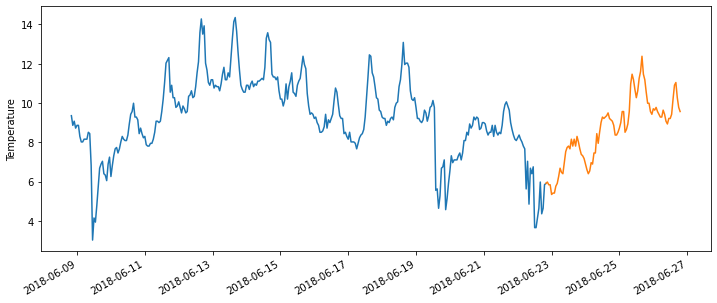

In [ ]:
import matplotlib.pyplot as plt

seq_len = 336
pred_len = 96

plt.figure(figsize=(12,5))
plt.ylabel('Temperature')
data_to_show = etth1_df.set_index(pd.to_datetime(etth1_df['date']))
plt.plot(data_to_show['OT'][-(seq_len + pred_len):-(pred_len - 1)])
plt.plot(data_to_show['OT'][-pred_len:])
plt.gcf().autofmt_xdate()
plt.show()

## 모델 구현체 준비

([A. Zeng et al., 2022](https://arxiv.org/pdf/2205.13504v2.pdf))에서 사용한 것과 같은 DLinear의 pytorch 구현체를 다운로드하고, 필요한 파이썬 패키지를 설치한다. 논문에서 제공하는 구현체가 ground truth에 대한 npy 파일을 생성하지 않도록 되어 있어서 구현체를 fork해 파일을 생성하도록 변경했다. (수정한 구현체 코드: https://github.com/parksb/LTSF-Linear) 필요하다면 requirements.txt에 포함된 파이썬 패키지를 설치한다.

In [ ]:
%cd /content
!git clone https://github.com/parksb/LTSF-Linear.git
%cd /content/LTSF-Linear
!ls

/content
fatal: destination path 'LTSF-Linear' already exists and is not an empty directory.
/content/LTSF-Linear
checkpoints    layers	Pyraformer	  run_stat.py
data_provider  LICENSE	README.md	  scripts
exp	       models	requirements.txt  utils
FEDformer      pics	run_longExp.py	  weight_plot.py


In [ ]:
#!pip install -r requirements.txt

## 하이퍼 파라미터 설정

각종 인자를 조정한다. 여기서는 `seq_len`(336)건의 과거 시계열 데이터를 학습해 `pred_len`(96)건의 미래 시계열을 예측한다. 다양한 데이터셋에 모델을 적용할 수 있도록 인자 객체 반환 함수를 작성해둔다.

In [ ]:
import os
import torch
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

def get_args(data_name, data_type, target, freq, io_size):
  args = dotdict()

  args.model = 'DLinear'

  args.data = data_type # 데이터 종류
  args.root_path = '/content/dataset/' # 데이터셋 디렉토리 경로
  args.data_path = '{}.csv'.format(data_name) # 데이터셋 파일명
  args.features = 'M' # 변량: [M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate]
  args.target = target # 예측할 타겟 피쳐
  args.freq = freq # 주기: [s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly]

  args.seq_len = seq_len # 입력 시퀀스 길이
  args.pred_len = pred_len # 예측 시퀀스 길이

  args.activation = 'gelu'
  args.loss = 'mse'
  args.num_workers = 10
  args.train_epochs = 10
  args.batch_size = 32
  args.patience = 3
  args.learning_rate = 0.0005
  args.dropout = 0.05

  args.enc_in = io_size
  args.des = 'Exp'
  args.checkpoints = './checkpoints/'
  args.model_id = '{}_{}_{}'.format(data_name, seq_len, pred_len)
  args.label_len = 48
  args.individual = False
  args.embed_type = 0
  args.dec_in = io_size
  args.c_out = io_size
  args.d_model = 512
  args.n_heads = 8
  args.e_layers = 2
  args.d_layers = 1
  args.d_ff = 2048
  args.moving_avg = 25
  args.factor = 1
  args.distil = True
  args.lradj = 'type1'
  args.embed = 'timeF'

  args.use_amp = False
  args.use_gpu = True if torch.cuda.is_available() else False
  args.gpu = 0
  args.use_multi_gpu = False
  args.devices = '0,1,2,3'
  args.test_flop = False

  if args.use_gpu and args.use_multi_gpu:
    args.dvices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
  
  return args

## 학습 및 테스트

앞서 설정한 하이퍼 파라미터를 이용해 모델을 정의한다. 이때 타겟 피쳐는 'OT' 컬럼이며, ETTh1은 시간 단위로 측정된 시계열 데이터이므로 주기는 'h'(hourly)로 설정한다.

In [ ]:
from exp.exp_main import Exp_Main

args = get_args('ETTh1', 'ETTh1', 'OT', 'h', 7)
exp = Exp_Main(args)
setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_0'.format(
  args.model_id, args.model, args.data, args.features, args.seq_len, args.label_len, args.pred_len,
  args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.factor, args.embed, args.distil, args.des)

Use GPU: cuda:0


데이터를 학습하고, 학습에 소요된 시간을 측정한다.

In [ ]:
import time

start = time.monotonic()
exp.train(setting)
end = time.monotonic()

print(end - start)

train 8209
val 2785
test 2785
	iters: 100, epoch: 1 | loss: 0.3700325
	speed: 0.0156s/iter; left time: 38.4609s
	iters: 200, epoch: 1 | loss: 0.3430304
	speed: 0.0058s/iter; left time: 13.6939s
Epoch: 1 cost time: 2.589700222015381
Epoch: 1, Steps: 256 | Train Loss: 0.4088630 Vali Loss: 0.6664551 Test Loss: 0.3947056
Validation loss decreased (inf --> 0.666455).  Saving model ...
Updating learning rate to 0.0005
	iters: 100, epoch: 2 | loss: 0.4436035
	speed: 0.0453s/iter; left time: 99.7893s
	iters: 200, epoch: 2 | loss: 0.3813843
	speed: 0.0103s/iter; left time: 21.6703s
Epoch: 2 cost time: 3.420760154724121
Epoch: 2, Steps: 256 | Train Loss: 0.3486942 Vali Loss: 0.6676258 Test Loss: 0.3806984
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00025
	iters: 100, epoch: 3 | loss: 0.4300076
	speed: 0.0559s/iter; left time: 108.9302s
	iters: 200, epoch: 3 | loss: 0.3399374
	speed: 0.0131s/iter; left time: 24.2467s
Epoch: 3 cost time: 3.7878990173339844
Epoch: 3, Steps: 256 | 

학습된 모델로 예측을 테스트하고, 테스트에 소요된 시간을 측정한다. 이때 MSE, MAE 지표를 확인할 수 있다.

In [ ]:
start = time.monotonic()
exp.test(setting, test=1)
end = time.monotonic()

print(end - start)

torch.cuda.empty_cache()

test 2785
loading model
test shape: (87, 32, 96, 7) (87, 32, 96, 7)
test shape: (2784, 96, 7) (2784, 96, 7)
mse:0.3782263696193695, mae:0.4001270532608032
1.054309982999996


예측 데이터를 실제 데이터와 함께 시각화해보면 아래와 같다.

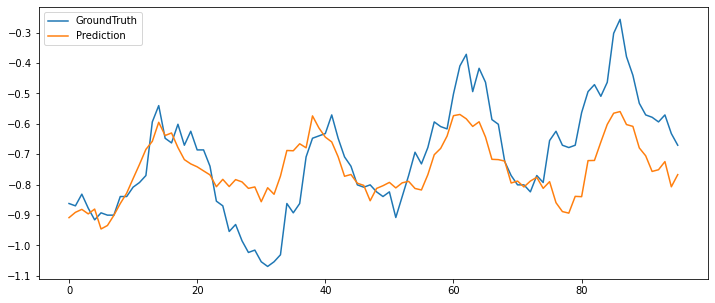

In [ ]:
pred = np.load('./results/{}/pred.npy'.format(setting))
trues = np.load('./results/{}/true.npy'.format(setting))

plt.figure(figsize=(12, 5))
plt.plot(trues[0,:,-1], label="GroundTruth")
plt.plot(pred[0,:,-1], label="Prediction")
plt.legend()
plt.show()